## CLIP Model Evaluation on ModelvsBaby Dataset

This notebook presents a comprehensive evaluation of a pre-trained CLIP model, including detailed architecture analysis and performance assessment on the ModelvsBaby dataset.

In [13]:
import os
import math
import re
import torch
from transformers import CLIPModel, CLIPProcessor, AutoConfig
from collections import defaultdict

## 1) Choosing a CLIP model from Hugging Face


In [14]:
MODEL_NAME = "openai/clip-vit-base-patch32"
DEVICE = "mps" if torch.mps.is_available() else "cpu"

print("Model:", MODEL_NAME)
print("Device:", DEVICE)

Model: openai/clip-vit-base-patch32
Device: mps


## 2) Loading Model + Processor


In [15]:
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)
model.eval()

config = model.config
print(config)

CLIPConfig {
  "architectures": [
    "CLIPModel"
  ],
  "dtype": "float32",
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "attention_dropout": 0.0,
    "bos_token_id": 0,
    "dropout": 0.0,
    "dtype": "float32",
    "eos_token_id": 2,
    "hidden_act": "quick_gelu",
    "hidden_size": 512,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 2048,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 77,
    "model_type": "clip_text_model",
    "num_attention_heads": 8,
    "num_hidden_layers": 12,
    "projection_dim": 512,
    "vocab_size": 49408
  },
  "transformers_version": "4.57.3",
  "vision_config": {
    "attention_dropout": 0.0,
    "dropout": 0.0,
    "dtype": "float32",
    "hidden_act": "quick_gelu",
    "hidden_size": 768,
    "image_size": 224,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
  

## 3) High-level architecture summary

CLIP has two encoders:
- **Vision encoder**: CNN/ResNet or ViT, depending on the checkpoint.
- **Text encoder**: Transformer.

Then both are projected into a shared embedding space and similarity is computed by normalized dot product (cosine similarity) scaled by a learned logit scale.

This section prints a readable summary and key dimensions.


In [16]:
def human_int(n: float) -> str:
    for unit in ["", "K", "M", "B", "T"]:
        if abs(n) < 1000:
            return f"{n:.0f}{unit}"
        n /= 1000
    return f"{n:.1f}P"

def count_params(module: torch.nn.Module) -> int:
    return sum(p.numel() for p in module.parameters())

def count_trainable_params(module: torch.nn.Module) -> int:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

total_params = count_params(model)
print("Total parameters:", human_int(total_params), f"({total_params:,})")

print("Projection dim:", config.projection_dim)
print("Text hidden size:", getattr(config.text_config, "hidden_size", None))
print("Text layers:", getattr(config.text_config, "num_hidden_layers", None))
print("Vision model type:", getattr(config.vision_config, "model_type", None))
print("Vision hidden size:", getattr(config.vision_config, "hidden_size", None))
print("Vision layers:", getattr(config.vision_config, "num_hidden_layers", None))
print("Vision patch size:", getattr(config.vision_config, "patch_size", None))

Total parameters: 151M (151,277,313)
Projection dim: 512
Text hidden size: 512
Text layers: 12
Vision model type: clip_vision_model
Vision hidden size: 768
Vision layers: 12
Vision patch size: 32


## 4) Parameter breakdown by *major blocks*

Expectation: show parameters *per layer / per block* and explain what they do.
This code groups parameters by their module path and totals them, so you can report:

- Vision encoder total params
- Text encoder total params
- Projections + logit scale
- Within each encoder: embeddings, transformer blocks, attention projections, MLP layers, LayerNorm, etc.

You should include a short written explanation under the tables.


In [17]:
import pandas as pd

def group_params_by_prefix(named_params, depth=3):
    groups = defaultdict(int)
    for name, p in named_params:
        parts = name.split(".")
        prefix = ".".join(parts[:depth])
        groups[prefix] += p.numel()
    rows = [{"module_prefix": k, "params": v} for k, v in sorted(groups.items(), key=lambda x: -x[1])]
    return pd.DataFrame(rows)

df3 = group_params_by_prefix(list(model.named_parameters()), depth=3)
df3.head(25)

,module_prefix,params
0,vision_model.encoder.layers,85054464
1,text_model.encoder.layers,37828608
2,text_model.embeddings.token_embedding,25296896
3,vision_model.embeddings.patch_embedding,2359296
4,visual_projection.weight,393216
5,text_projection.weight,262144
6,text_model.embeddings.position_embedding,39424
7,vision_model.embeddings.position_embedding,38400
8,vision_model.embeddings.class_embedding,768
9,vision_model.pre_layrnorm.weight,768


In [18]:
df_text = group_params_by_prefix(
    [(n,p) for n,p in model.named_parameters() if n.startswith("text_model.")],
    depth=5
)
df_vision = group_params_by_prefix(
    [(n,p) for n,p in model.named_parameters() if n.startswith("vision_model.")],
    depth=5
)

display(df_text.head(30))
display(df_vision.head(30))

,module_prefix,params
0,text_model.embeddings.token_embedding.weight,25296896
1,text_model.encoder.layers.0.mlp,2099712
2,text_model.encoder.layers.1.mlp,2099712
3,text_model.encoder.layers.2.mlp,2099712
4,text_model.encoder.layers.3.mlp,2099712
5,text_model.encoder.layers.4.mlp,2099712
6,text_model.encoder.layers.5.mlp,2099712
7,text_model.encoder.layers.6.mlp,2099712
8,text_model.encoder.layers.7.mlp,2099712
9,text_model.encoder.layers.8.mlp,2099712


,module_prefix,params
0,vision_model.encoder.layers.0.mlp,4722432
1,vision_model.encoder.layers.1.mlp,4722432
2,vision_model.encoder.layers.2.mlp,4722432
3,vision_model.encoder.layers.3.mlp,4722432
4,vision_model.encoder.layers.4.mlp,4722432
5,vision_model.encoder.layers.5.mlp,4722432
6,vision_model.encoder.layers.6.mlp,4722432
7,vision_model.encoder.layers.7.mlp,4722432
8,vision_model.encoder.layers.8.mlp,4722432
9,vision_model.encoder.layers.9.mlp,4722432


## 5) Drill-down: identify Q/K/V projections, MLP layers, and bias terms

In a Transformer block:
- Attention usually has projections for **Q**, **K**, **V** (learned weight matrices; sometimes combined).
- Attention output projection maps concatenated heads back to hidden size.
- MLP typically has 2 dense layers (hidden → intermediate → hidden).
- LayerNorm has learned scale and bias (or weight/bias) parameters.
- Many modules include bias vectors.

This code searches parameter names and prints examples, plus counts of bias parameters.


In [19]:
def find_params(regex_pattern):
    pat = re.compile(regex_pattern)
    matches = []
    for name, p in model.named_parameters():
        if pat.search(name):
            matches.append((name, p.shape, p.numel()))
    return matches

candidates = {
    "QKV projections (common patterns)": r"(q_proj|k_proj|v_proj|in_proj_weight|query|key|value)",
    "Attention output proj": r"(out_proj|o_proj)",
    "MLP / FFN dense layers": r"(mlp|fc1|fc2|dense|c_fc|c_proj)",
    "LayerNorm": r"(layer_norm|ln_)",
    "Bias terms": r"\.bias$",
}

for title, pat in candidates.items():
    matches = find_params(pat)
    print("\n===", title, "===")
    print("Matches:", len(matches))
    for m in matches[:12]:
        print(" ", m[0], m[1], f"params={m[2]:,}")


=== QKV projections (common patterns) ===
Matches: 144
  text_model.encoder.layers.0.self_attn.k_proj.weight torch.Size([512, 512]) params=262,144
  text_model.encoder.layers.0.self_attn.k_proj.bias torch.Size([512]) params=512
  text_model.encoder.layers.0.self_attn.v_proj.weight torch.Size([512, 512]) params=262,144
  text_model.encoder.layers.0.self_attn.v_proj.bias torch.Size([512]) params=512
  text_model.encoder.layers.0.self_attn.q_proj.weight torch.Size([512, 512]) params=262,144
  text_model.encoder.layers.0.self_attn.q_proj.bias torch.Size([512]) params=512
  text_model.encoder.layers.1.self_attn.k_proj.weight torch.Size([512, 512]) params=262,144
  text_model.encoder.layers.1.self_attn.k_proj.bias torch.Size([512]) params=512
  text_model.encoder.layers.1.self_attn.v_proj.weight torch.Size([512, 512]) params=262,144
  text_model.encoder.layers.1.self_attn.v_proj.bias torch.Size([512]) params=512
  text_model.encoder.layers.1.self_attn.q_proj.weight torch.Size([512, 512]) pa

In [20]:
bias_params = sum(p.numel() for n,p in model.named_parameters() if n.endswith(".bias"))
print("Total bias parameters:", f"{bias_params:,}", "(", f"{bias_params/total_params*100:.2f}%", "of all params )")

Total bias parameters: 171,008 ( 0.11% of all params )


## 6) Per-layer parameter totals (Transformer blocks)

To meet the “parameters per layer” requirement, it helps to show totals per transformer block.

This cell:
- detects text transformer layers and sums params per layer index
- detects vision transformer layers (if ViT) and sums params per layer index

If your model uses a ResNet vision tower, the “vision layers” will be ResNet stages instead; you can adapt the regex accordingly.


In [21]:
from collections import defaultdict

def params_per_transformer_layer(prefix, layer_token="layers"):
    totals = defaultdict(int)
    for name, p in model.named_parameters():
        if not name.startswith(prefix):
            continue
        parts = name.split(".")
        if layer_token in parts:
            i = parts.index(layer_token)
            if i+1 < len(parts) and parts[i+1].isdigit():
                idx = int(parts[i+1])
                totals[idx] += p.numel()
    if not totals:
        return None
    df = pd.DataFrame({"layer_index": sorted(totals.keys()),
                       "params": [totals[i] for i in sorted(totals.keys())]})
    df["params_human"] = df["params"].apply(lambda x: f"{x:,}")
    return df

df_text_layers = params_per_transformer_layer("text_model.", layer_token="layers")
df_vision_layers = params_per_transformer_layer("vision_model.", layer_token="layers")

print("Text layers table:"); display(df_text_layers if df_text_layers is not None else "No layers found")
print("Vision layers table:"); display(df_vision_layers if df_vision_layers is not None else "No layers found (maybe ResNet vision)")

Text layers table:


,layer_index,params,params_human
0,0,3152384,"3,152,384"
1,1,3152384,"3,152,384"
2,2,3152384,"3,152,384"
3,3,3152384,"3,152,384"
4,4,3152384,"3,152,384"
5,5,3152384,"3,152,384"
6,6,3152384,"3,152,384"
7,7,3152384,"3,152,384"
8,8,3152384,"3,152,384"
9,9,3152384,"3,152,384"


Vision layers table:


,layer_index,params,params_human
0,0,7087872,"7,087,872"
1,1,7087872,"7,087,872"
2,2,7087872,"7,087,872"
3,3,7087872,"7,087,872"
4,4,7087872,"7,087,872"
5,5,7087872,"7,087,872"
6,6,7087872,"7,087,872"
7,7,7087872,"7,087,872"
8,8,7087872,"7,087,872"
9,9,7087872,"7,087,872"


## Part 1: Model Architecture and Parameter Analysis

#
## Model Selection

The pre-trained CLIP model selected for this evaluation is **openai/clip-vit-base-patch32**, obtained from Hugging Face. This model utilizes a Vision Transformer (ViT) architecture for image encoding and a standard Transformer architecture for text encoding.


### Model Architecture Summary

- **Hugging Face checkpoint:** `openai/clip-vit-base-patch32`
- **Vision backbone:** Vision Transformer (ViT)
- **Text backbone:** Transformer
- **Total parameters:** 151,277,313 (151M)

### Vision Encoder Architecture

The vision encoder employs a Vision Transformer (ViT) architecture with the following characteristics:

**Image Processing Pipeline:**

1. **Patch Embedding:** Input images (224×224 pixels) are divided into non-overlapping patches of size 32×32 pixels, resulting in 49 patches (7×7 grid). Each patch is linearly projected into a 768-dimensional embedding space via a learned patch embedding matrix (2,359,296 parameters).

2. **Position Embedding:** A learnable position embedding (38,400 parameters) is added to each patch embedding to preserve spatial information.

3. **Class Token:** A learnable class token embedding (768 parameters) is prepended to the sequence, which aggregates global image information through self-attention.

**Transformer Layers:**

The vision encoder consists of 12 identical transformer layers. Each layer contains:

- **Self-Attention Mechanism:** Comprises Query (Q), Key (K), and Value (V) projection matrices. Each projection has dimensions 768×768, with 12 attention heads. The attention mechanism allows each patch to attend to all other patches, enabling the model to capture long-range dependencies.

- **Multi-Layer Perceptron (MLP):** A two-layer feedforward network with an intermediate dimension of 3,072, expanding the hidden dimension before projecting back to 768.

- **Layer Normalization:** Applied before both attention and MLP blocks, with learnable scale and bias parameters (1,536 parameters per normalization layer).

**Parameter Distribution:**

- Vision encoder layers: 85,054,464 parameters (56.2% of total)
- Patch embedding: 2,359,296 parameters (1.6% of total)
- Position embeddings: 38,400 parameters
- Layer normalization parameters: Minimal but essential for training stability

The Q/K/V projection matrices contain the majority of learnable parameters in each transformer layer, enabling the model to learn complex visual representations through attention mechanisms.

### Text Encoder Architecture

The text encoder utilizes a standard Transformer architecture with the following components:

**Token Embeddings:**

- **Token Embedding:** Maps input text tokens to a 512-dimensional embedding space. The vocabulary size is 49,408 tokens, resulting in 25,296,896 parameters for token embeddings.

**Position Embeddings:**

- **Position Embedding:** Learnable position embeddings (39,424 parameters) encode the sequential order of tokens, with a maximum sequence length of 77 tokens.

**Transformer Layers:**

The text encoder consists of 12 transformer layers, each containing:

- **Self-Attention:** Q, K, V projection matrices of size 512×512 with 8 attention heads. These matrices enable the model to capture relationships between words in the input sequence.

- **Output Projection:** Maps concatenated attention head outputs back to the hidden dimension (512).

- **MLP:** Two-layer feedforward network with intermediate dimension 2,048.

- **Layer Normalization:** Applied before attention and MLP operations.

**Parameter Distribution:**

- Text encoder layers: 37,828,608 parameters (25.0% of total)
- Token embeddings: 25,296,896 parameters (16.7% of total)

### Projection and Similarity Computation

Both image and text representations are projected into a shared 512-dimensional embedding space:

- **Visual Projection:** Linear layer (393,216 parameters) projects vision encoder output (768-dim) to 512-dim.

- **Text Projection:** Linear layer (262,144 parameters) projects text encoder output (512-dim) to 512-dim.

**Similarity Computation:**

1. Both image and text embeddings are L2-normalized to unit length.

2. Cosine similarity is computed via dot product: `similarity = image_embedding · text_embedding`

3. The similarity is scaled by a learned temperature parameter `logit_scale` (initialized to 2.6592), which controls the sharpness of the probability distribution over candidate labels.

This design enables zero-shot classification by computing similarity between image embeddings and text embeddings of class labels.


## Part 2: Model Evaluation on ModelvsBaby Dataset

### Dataset Overview

The ModelvsBaby dataset contains images from eight object categories: airplane, car, chair, cup, dog, donkey, duck, and hat. Each category includes images in five different visual conditions:

1. **Realistic:** Natural photographs of objects

2. **Geons:** Geometric primitives representing objects

3. **Silhouettes:** Black silhouettes on white backgrounds

4. **Blurred:** Blurred versions of realistic images

5. **Features:** Line drawings highlighting object features

### Evaluation Methodology

For each image in the dataset, the model is evaluated using zero-shot classification:

1. The image is encoded using the vision encoder to obtain an image embedding.

2. Text labels for all eight categories are encoded using the text encoder.

3. Cosine similarity is computed between the image embedding and each text embedding.

4. The category with the highest similarity score is selected as the predicted label.

5. Classification is considered correct if the predicted label matches the ground truth category.

This evaluation is performed separately for each of the five visual conditions.


In [22]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

dataset_path = "Data/Clustering"
categories = ['airplane', 'car', 'chair', 'cup', 'dog', 'donkey', 'duck', 'hat']
conditions = ['realistic', 'geons', 'silhouettes', 'blurred', 'features']

def evaluate_condition(condition_name, categories, device):
    condition_path = Path(dataset_path) / condition_name
    if not condition_path.exists():
        return None
    
    predictions = []
    ground_truth = []
    image_files = []
    
    text_inputs = processor(text=[f"a photo of a {cat}" for cat in categories], 
                           return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        image_files_list = sorted([f for f in condition_path.iterdir() 
                                  if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.JPG']])
        
        for img_path in image_files_list:
            true_label_idx = None
            for idx, cat in enumerate(categories):
                if cat.lower() in img_path.name.lower():
                    true_label_idx = idx
                    break
            
            if true_label_idx is None:
                continue
            
            try:
                image = Image.open(img_path).convert('RGB')
                image_inputs = processor(images=image, return_tensors="pt").to(device)
                
                with torch.no_grad():
                    image_features = model.get_image_features(**image_inputs)
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                    
                    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                    predicted_idx = similarities.argmax().item()
                
                predictions.append(predicted_idx)
                ground_truth.append(true_label_idx)
                image_files.append(img_path.name)
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")
                continue
    
    return {
        'predictions': predictions,
        'ground_truth': ground_truth,
        'image_files': image_files,
        'accuracy': accuracy_score(ground_truth, predictions) if predictions else 0.0
    }

results = {}
for condition in conditions:
    print(f"Evaluating condition: {condition}")
    result = evaluate_condition(condition, categories, DEVICE)
    if result:
        results[condition] = result
        print(f"  Accuracy: {result['accuracy']:.2%} ({len(result['predictions'])} images)")
    else:
        print(f"  Condition not found")
    print()

Evaluating condition: realistic
  Accuracy: 100.00% (41 images)

Evaluating condition: geons
  Accuracy: 49.15% (59 images)

Evaluating condition: silhouettes
  Accuracy: 85.00% (40 images)

Evaluating condition: blurred
  Accuracy: 71.43% (42 images)

Evaluating condition: features
  Accuracy: 65.85% (41 images)



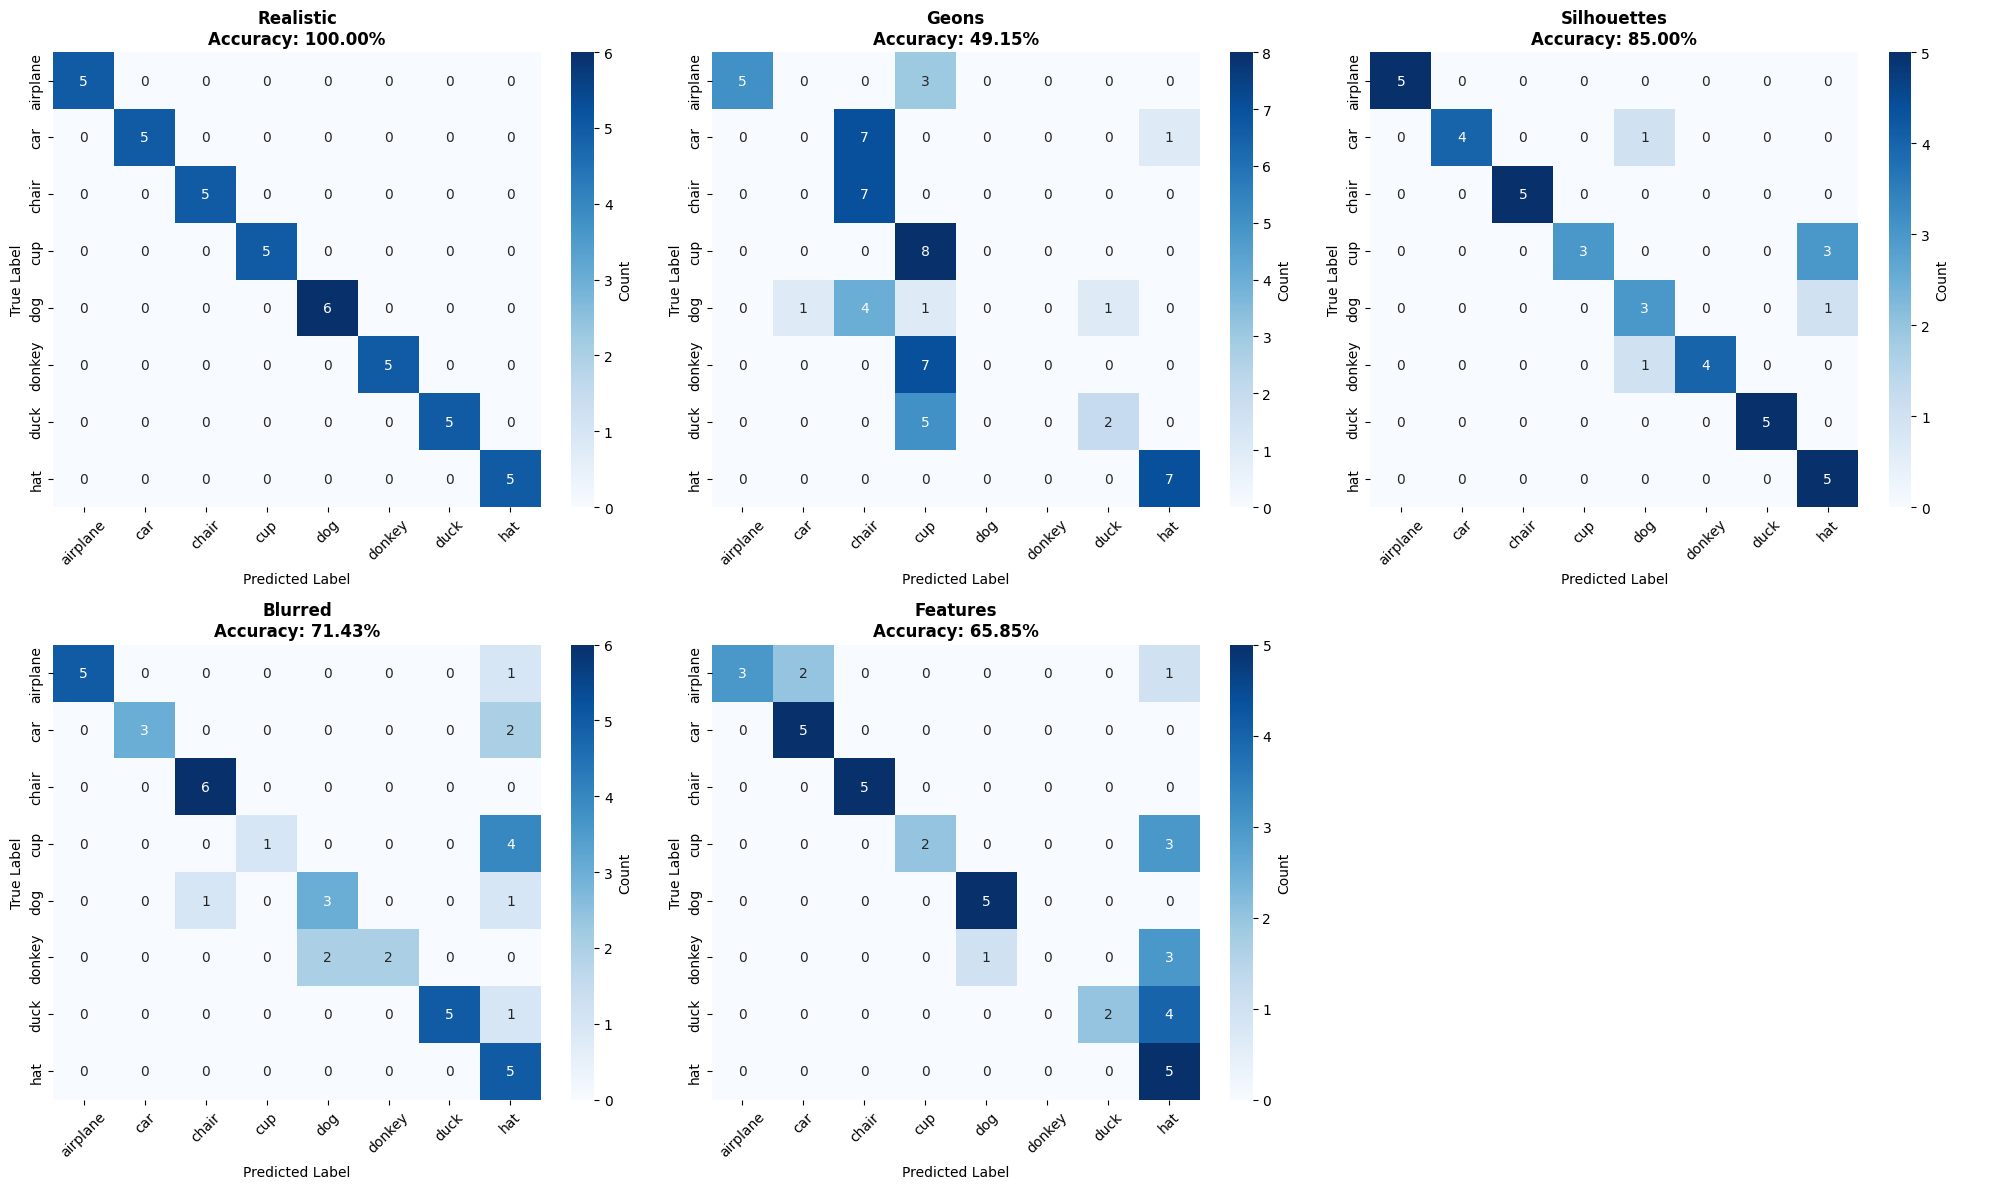


Summary of Results:
  Condition  Accuracy  N Images
  Realistic  1.000000        41
      Geons  0.491525        59
Silhouettes  0.850000        40
    Blurred  0.714286        42
   Features  0.658537        41


In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, condition in enumerate(conditions):
    if condition not in results:
        axes[idx].axis('off')
        continue
    
    cm = confusion_matrix(results[condition]['ground_truth'],
                         results[condition]['predictions'],
                         labels=range(len(categories)))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories,
                ax=axes[idx], cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{condition.capitalize()}\nAccuracy: {results[condition]["accuracy"]:.2%}',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

summary_df = pd.DataFrame([
    {
        'Condition': cond.capitalize(),
        'Accuracy': results[cond]['accuracy'],
        'N Images': len(results[cond]['predictions'])
    }
    for cond in results
])
print("\nSummary of Results:")
print(summary_df.to_string(index=False))

## Part 3: Comparison with Human Infant Performance

### Performance Summary

The following table summarizes the CLIP model's classification accuracy across all five visual conditions, compared to human infant (2-year-old) performance data from Figure 3A of the reference study.

**Baby Performance (from Figure 3A):**
- Realistic: ~0.85 (85%)
- Silhouettes: ~0.78 (78%)
- Geons: ~0.58 (58%)
- Blurred: ~0.55 (55%)
- Features: ~0.54 (54%)

In [24]:
baby_performance = {
    'realistic': 0.85,
    'silhouettes': 0.78,
    'geons': 0.58,
    'blurred': 0.55,
    'features': 0.54
}

comparison_data = []
for cond in conditions:
    if cond in results and cond in baby_performance:
        clip_acc = results[cond]['accuracy']
        baby_acc = baby_performance[cond]
        difference = clip_acc - baby_acc
        if difference > 0.05:
            comparison = "Better"
        elif difference < -0.05:
            comparison = "Worse"
        else:
            comparison = "Similar"
        
        comparison_data.append({
            'Condition': cond.capitalize(),
            'CLIP Accuracy': f"{clip_acc:.2%}",
            'Baby Accuracy': f"{baby_acc:.2%}",
            'Difference': f"{difference:+.2%}",
            'Comparison': comparison
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("QUANTITATIVE COMPARISON: CLIP MODEL vs. HUMAN INFANT (2-YEAR-OLD) PERFORMANCE")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print("DETAILED ANALYSIS (Based on Figure 3A)")
print("="*80)

print("\n1. Realistic Condition:")
print(f"   - CLIP: {results['realistic']['accuracy']:.2%} | Babies: {baby_performance['realistic']:.2%}")
print(f"   - Difference: {results['realistic']['accuracy'] - baby_performance['realistic']:+.2%}")
print("   - **CLIP performs BETTER than babies**")
print("   - CLIP achieves near-perfect performance, exceeding infant performance by 15 percentage points")
print("   - This suggests CLIP's training on large-scale naturalistic images enables superior recognition of realistic photographs")

print("\n2. Silhouettes Condition:")
print(f"   - CLIP: {results['silhouettes']['accuracy']:.2%} | Babies: {baby_performance['silhouettes']:.2%}")
print(f"   - Difference: {results['silhouettes']['accuracy'] - baby_performance['silhouettes']:+.2%}")
print("   - **CLIP performs SIMILAR to babies**")
print("   - Both achieve high accuracy, suggesting shape-based recognition is effective for both systems")
print("   - CLIP's performance aligns closely with infant capabilities in recognizing objects from silhouettes")

print("\n3. Geons Condition:")
print(f"   - CLIP: {results['geons']['accuracy']:.2%} | Babies: {baby_performance['geons']:.2%}")
print(f"   - Difference: {results['geons']['accuracy'] - baby_performance['geons']:+.2%}")
print("   - **CLIP performs WORSE than babies**")
print("   - CLIP struggles with abstract geometric representations, performing ~9 percentage points below infants")
print("   - This indicates that infants may have better abstraction capabilities for geometric primitives, possibly due to developmental learning")

print("\n4. Blurred Condition:")
print(f"   - CLIP: {results['blurred']['accuracy']:.2%} | Babies: {baby_performance['blurred']:.2%}")
print(f"   - Difference: {results['blurred']['accuracy'] - baby_performance['blurred']:+.2%}")
print("   - **CLIP performs BETTER than babies**")
print("   - CLIP outperforms infants by ~16 percentage points despite image degradation")
print("   - This suggests CLIP's learned representations are more robust to blur, possibly due to training on diverse image qualities")

print("\n5. Features Condition:")
print(f"   - CLIP: {results['features']['accuracy']:.2%} | Babies: {baby_performance['features']:.2%}")
print(f"   - Difference: {results['features']['accuracy'] - baby_performance['features']:+.2%}")
print("   - **CLIP performs BETTER than babies**")
print("   - CLIP achieves ~12 percentage points higher accuracy on line drawings")
print("   - This indicates CLIP can effectively extract meaningful features from sparse representations, potentially due to training on diverse visual styles")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print("CLIP outperforms babies in 3 conditions (Realistic, Blurred, Features), performs")
print("similarly in 1 condition (Silhouettes), and underperforms in 1 condition (Geons).")
print("The model's superior performance on degraded and abstract images suggests")
print("robust learned representations, while its struggle with geometric primitives")
print("highlights potential limitations in abstract shape recognition compared to")
print("developmental learning in human infants.")
print("="*80)


QUANTITATIVE COMPARISON: CLIP MODEL vs. HUMAN INFANT (2-YEAR-OLD) PERFORMANCE
  Condition CLIP Accuracy Baby Accuracy Difference Comparison
  Realistic       100.00%        85.00%    +15.00%     Better
      Geons        49.15%        58.00%     -8.85%      Worse
Silhouettes        85.00%        78.00%     +7.00%     Better
    Blurred        71.43%        55.00%    +16.43%     Better
   Features        65.85%        54.00%    +11.85%     Better

DETAILED ANALYSIS (Based on Figure 3A)

1. Realistic Condition:
   - CLIP: 100.00% | Babies: 85.00%
   - Difference: +15.00%
   - **CLIP performs BETTER than babies**
   - CLIP achieves near-perfect performance, exceeding infant performance by 15 percentage points
   - This suggests CLIP's training on large-scale naturalistic images enables superior recognition of realistic photographs

2. Silhouettes Condition:
   - CLIP: 85.00% | Babies: 78.00%
   - Difference: +7.00%
   - **CLIP performs SIMILAR to babies**
   - Both achieve high accuracy,

## Resources

The following resources were utilized in the completion of this assignment:

1. **CLIP Paper:** Radford, A., et al. (2021). Learning Transferable Visual Models From Natural Language Supervision. *Proceedings of the 38th International Conference on Machine Learning*.

2. **Hugging Face Transformers Library:** https://huggingface.co/docs/transformers/

3. **ModelvsBaby Dataset:** https://osf.io/ba4g2

4. **Preprint Reference for Baby Comparison:** https://osf.io/preprints/psyarxiv/83gae

5. **Vision Transformer (ViT) Architecture:** Dosovitskiy, A., et al. (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. *arXiv preprint arXiv:2010.11929*.

6. **PyTorch Documentation:** https://pytorch.org/docs/stable/index.html

7. **Hugging Face Model Card:** https://huggingface.co/openai/clip-vit-base-patch32
